# Salmon

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [2]:
# download modsim.py if necessary

from os.path import exists

filename = 'modsim.py'
if not exists(filename):
    from urllib.request import urlretrieve
    url = 'https://raw.githubusercontent.com/AllenDowney/ModSim/main/'
    local, _ = urlretrieve(url+filename, filename)
    print('Downloaded ' + local)

In [1]:
# import functions from modsim

import numpy
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import modsim

## Can we predict salmon populations?

Each year the [U.S. Atlantic Salmon Assessment Committee](https://www.nefsc.noaa.gov/USASAC/Reports/USASAC2018-Report-30-2017-Activities.pdf) reports estimates of salmon populations in oceans and rivers in the northeastern United States.  The reports are useful for monitoring changes in these populations, but they generally do not include predictions.

The goal of this case study is to model year-to-year changes in population, evaluate how predictable these changes are, and estimate the probability that a particular population will increase or decrease in the next 10 years.

As an example, I'll use data from page 18 of the 2017 report, which provides population estimates for the Narraguagus and Sheepscot Rivers in Maine.

![USASAC_Report_2017_Page18](https://github.com/AllenDowney/ModSim/raw/main/data/USASAC_Report_2017_Page18.png)

There are tools for extracting data from a PDF document automatically, but for this example I will keep it simple and type it in.

Here are the population estimates for the Narraguagus River:

In [2]:
pops = [2749, 2845, 4247, 1843, 2562, 1774, 1201, 1284, 1287, 
        2339, 1177, 962, 1176, 2149, 1404, 969, 1237, 1615, 1201]
len(pops)

19

To get this data into a Pandas Series, I'll also make a range of years to use as an index.

In [3]:
years = modsim.linrange(1997, 2016)
years, len(years)

(array([1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
        2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]),
 19)

And here's the series.

In [4]:
pop_series = modsim.TimeSeries(pops, index=years)
pop_series

,values
1997,2749
1998,2845
1999,4247
2000,1843
2001,2562
2002,1774
2003,1201
2004,1284
2005,1287
2006,2339


Here's what it looks like:

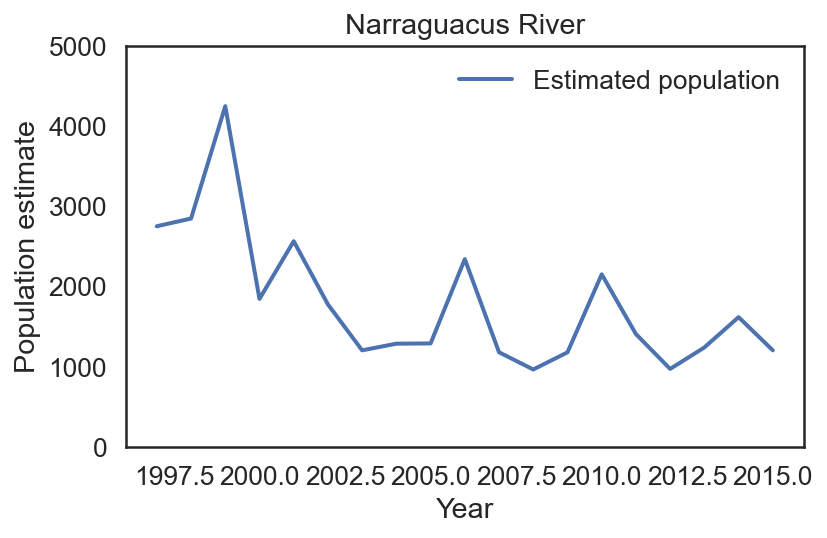

In [5]:
def plot_population(series):
    series.plot(label='Estimated population')
    modsim.decorate(xlabel='Year', 
             ylabel='Population estimate', 
             title='Narraguacus River',
             ylim=[0, 5000])
    
plot_population(pop_series)

## Modeling changes

To see how the population changes from year-to-year, I'll use `diff` to compute the absolute difference between each year and the next.


In [6]:
abs_diffs = pop_series.diff()
abs_diffs

1997       NaN
1998      96.0
1999    1402.0
2000   -2404.0
2001     719.0
2002    -788.0
2003    -573.0
2004      83.0
2005       3.0
2006    1052.0
2007   -1162.0
2008    -215.0
2009     214.0
2010     973.0
2011    -745.0
2012    -435.0
2013     268.0
2014     378.0
2015    -414.0
dtype: float64

We can compute relative differences by dividing by the original series elementwise.

In [7]:
rel_diffs = abs_diffs / pop_series
rel_diffs

1997         NaN
1998    0.033743
1999    0.330115
2000   -1.304395
2001    0.280640
2002   -0.444194
2003   -0.477102
2004    0.064642
2005    0.002331
2006    0.449765
2007   -0.987256
2008   -0.223493
2009    0.181973
2010    0.452769
2011   -0.530627
2012   -0.448916
2013    0.216653
2014    0.234056
2015   -0.344713
dtype: float64

These relative differences are observed annual net growth rates.  So let's drop the `0` and save them.

In [8]:
rates = rel_diffs.dropna()
rates

1998    0.033743
1999    0.330115
2000   -1.304395
2001    0.280640
2002   -0.444194
2003   -0.477102
2004    0.064642
2005    0.002331
2006    0.449765
2007   -0.987256
2008   -0.223493
2009    0.181973
2010    0.452769
2011   -0.530627
2012   -0.448916
2013    0.216653
2014    0.234056
2015   -0.344713
dtype: float64

A simple way to model this system is to draw a random value from this series of observed rates each year.  We can use the NumPy function `choice` to make a random choice from a series.

In [9]:
numpy.random.choice(rates)

0.002331002331002331

## Simulation

Now we can simulate the system by drawing random growth rates from the series of observed rates.

I'll start the simulation in 2015.

In [10]:
t_0 = 2015
p_0 = pop_series[t_0]

I'll create a `System` object with variables `t_0`, `p_0`, `rates`, and `duration=10` years. 

The series of observed rates is one big parameter of the model.

In [11]:
system = modsim.System(t_0=t_0,
                p_0=p_0,
                duration=10,
                rates=rates)

Write an update function that takes as parameters `pop`, `t`, and `system`.
It should choose a random growth rate, compute the change in population, and return the new population.

In [24]:
# Solution goes here
def update_func1(pop, t, system):
    rate = numpy.random.choice(system.rates)
    pop += rate*pop
    return pop

Test your update function and run it a few times

In [27]:
update_func1(p_0, t_0, system)

-365.57840477482364

Here's a version of `run_simulation` that stores the results in a `TimeSeries` and returns it.

In [19]:
def run_simulation(system, update_func):
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    """
    t_0 = system.t_0
    t_end = t_0 + system.duration
    
    results = modsim.TimeSeries()
    results[t_0] = system.p_0
    
    for t in modsim.linrange(t_0, t_end):
        results[t+1] = update_func(results[t], t, system)

    return results

Use `run_simulation` to run generate a prediction for the next 10 years.

The plot your prediction along with the original data.  Your prediction should pick up where the data leave off.

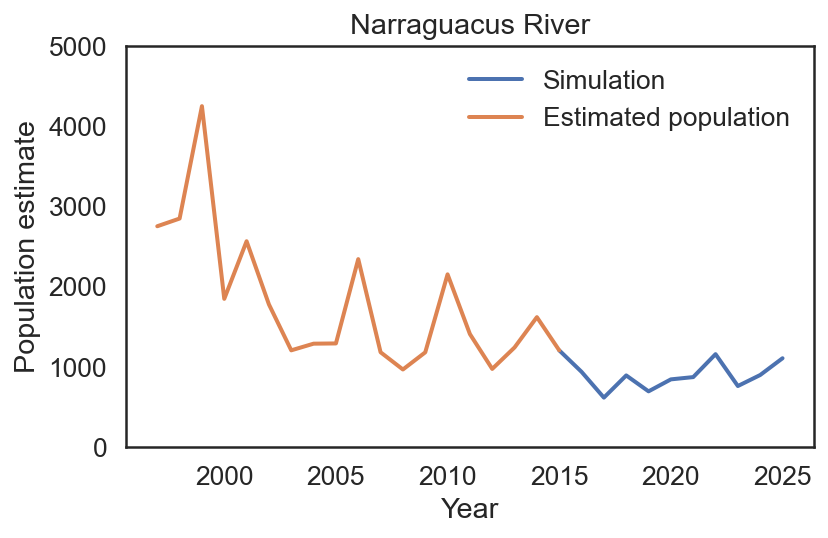

In [68]:
# Solution goes here
results = run_simulation(system, update_func1)
results.plot(label="Simulation")
plot_population(pop_series)

To get a sense of how much the results vary, we can run the model several times and plot all of the results.

In [21]:
def plot_many_simulations(system, update_func, iters):
    """Runs simulations and plots the results.
    
    system: System object
    update_func: function object
    iters: number of simulations to run
    """
    for i in range(iters):
        results = run_simulation(system, update_func)
        results.plot(color='gray', label='_nolegend', 
                     linewidth=1, alpha=0.3)

The plot option `alpha=0.1` makes the lines semi-transparent, so they are darker where they overlap.

Run `plot_many_simulations` with your update function and `iters=30`.  Also plot the original data.

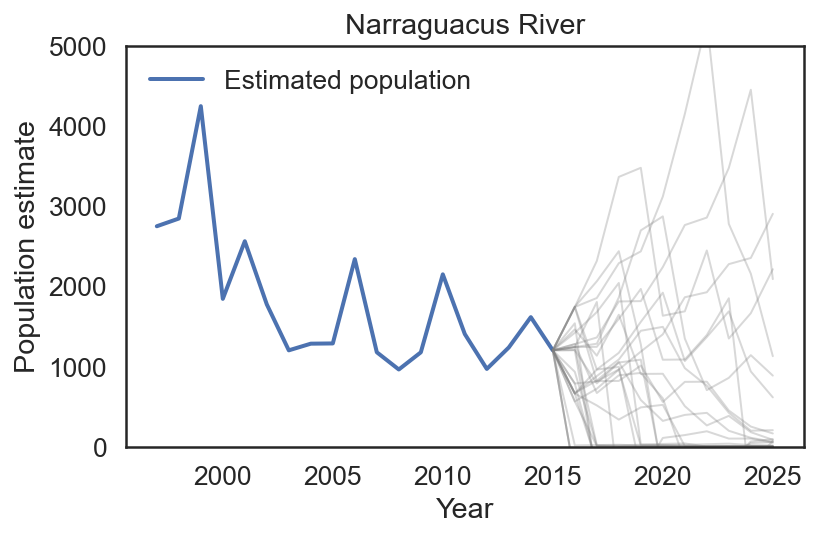

In [70]:
# Solution goes here
plot_population(pop_series)
plot_many_simulations(system, update_func1, 30)

The results are highly variable: according to this model, the population might continue to decline over the next 10 years, or it might recover and grow rapidly!

It's hard to say how seriously we should take this model.  There are many factors that influence salmon populations that are not included in the model.  For example, if the population starts to grow quickly, it might be limited by resource limits, predators, or fishing.  If the population starts to fall, humans might restrict fishing and stock the river with farmed fish.

So these results should probably not be considered useful predictions.  However, there might be something useful we can do, which is to estimate the probability that the population will increase or decrease in the next 10 years.  

## Distribution of net changes

To describe the distribution of net changes, write a function called `run_many_simulations` that runs many simulations, saves the final populations in a `ModSimSeries`, and returns the `ModSimSeries`.


In [130]:
def run_many_simulations(system, update_func, iters):
    """Runs simulations and report final populations.
    
    system: System object
    update_func: function object
    iters: number of simulations to run
    
    returns: series of final populations
    """
    # FILL THIS IN
    results = modsim.ModSimSeries()

    for i in range(iters):
        x = run_simulation(system, update_func)
        results[i] = x.iloc[-1]
        
    return results

In [131]:
# Solution goes here
results_dist = run_many_simulations(system, update_func1, 30)

Test your function by running it with `iters=5`.

In [132]:
a = run_many_simulations(system, update_func1, 5)
a

,values
0,53.098121
1,-2.653271
2,0.138172
3,-0.007926
4,-0.429123


Now we can run 1000 simulations and describe the distribution of the results.

In [119]:
last_pops = run_many_simulations(system, update_func1, 1000)
last_pops.describe()

count     1000.000000
mean       273.557093
std       1243.852739
min      -3300.294488
25%         -3.641022
50%          3.188768
75%        201.687314
max      17810.156969
dtype: float64

If we substract off the initial population, we get the distribution of changes.

In [120]:
net_changes = last_pops - p_0
net_changes.describe()

count     1000.000000
mean      -927.442907
std       1243.852739
min      -4501.294488
25%      -1204.641022
50%      -1197.811232
75%       -999.312686
max      16609.156969
dtype: float64

The median is negative, which indicates that the population decreases more often than it increases.

We can be more specific by counting the number of runs where `net_changes` is positive.

In [121]:
numpy.sum(net_changes > 0)

75

Or we can use `mean` to compute the fraction of runs where `net_changes` is positive.

In [122]:
numpy.mean(net_changes > 0)

0.075

And here's the fraction where it's negative.

In [123]:
numpy.mean(net_changes < 0)

0.925

So, based on observed past changes, this model predicts that the population is more likely to decrease than increase over the next 10 years, by about 2:1.

## A refined model

There are a few ways we could improve the model.

1.  It looks like there might be cyclic behavior in the past data, with a period of 4-5 years.  We could extend the model to include this effect.

2.  Older data might not be as relevant for prediction as newer data, so we could give more weight to newer data.

The second option is easier to implement, so let's try it.

I'll use `linspace` to create an array of "weights" for the observed rates.  The probability that I choose each rate will be proportional to these weights.

The weights have to add up to 1, so I divide through by the total.

In [133]:
weights = numpy.linspace(0, 1, len(rates))
weights /= sum(weights)
weights

array([0.        , 0.00653595, 0.0130719 , 0.01960784, 0.02614379,
       0.03267974, 0.03921569, 0.04575163, 0.05228758, 0.05882353,
       0.06535948, 0.07189542, 0.07843137, 0.08496732, 0.09150327,
       0.09803922, 0.10457516, 0.11111111])

I'll add the weights to the `System` object, since they are parameters of the model.

In [134]:
system.weights = weights

We can pass these weights as a parameter to `np.random.choice` (see the [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html))

In [137]:
numpy.random.choice(system.rates, p=system.weights)

-0.2234927234927235

Write an update function that takes the weights into account.

In [138]:
# Solution goes here
def update_func2(pop, t, system):
    rate = numpy.random.choice(system.rates, p=system.weights)
    pop += rate*pop
    return pop

Use `plot_many_simulations` to plot the results.

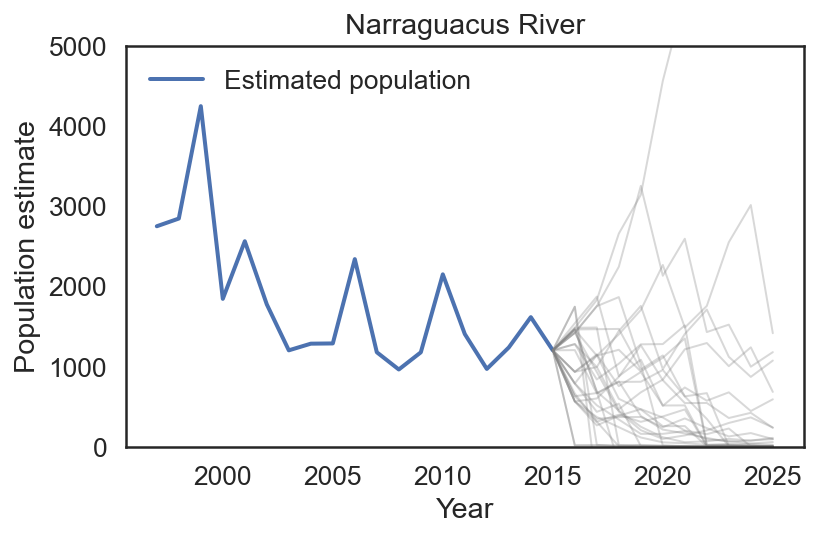

In [139]:
# Solution goes here
plot_population(pop_series)
plot_many_simulations(system, update_func2, 30)

Use `run_many_simulations` to collect the results and `describe` to summarize the distribution of net changes.

In [143]:
# Solution goes here
last_pops = run_many_simulations(system, update_func2, 1000)
last_pops.describe()

count    1000.000000
mean      355.556483
std       835.576994
min     -1316.796963
25%         0.806629
50%        29.471010
75%       343.915651
max      7522.564052
dtype: float64

Does the refined model have much effect on the probability of population decline?

In [144]:
# Solution goes here
net_changes = last_pops - p_0
net_changes.describe()

count    1000.000000
mean     -845.443517
std       835.576994
min     -2517.796963
25%     -1200.193371
50%     -1171.528990
75%      -857.084349
max      6321.564052
dtype: float64

In [145]:
numpy.mean(net_changes > 0), numpy.mean(net_changes < 0)

(0.09, 0.91)